# Learn to plot Bayesian Network

In [1]:
!pip install cython
!pip install "vose<0.0.2" --no-build-isolation
!pip install sorobn
!pip install graphviz

In [2]:
import graphviz

dot = graphviz.Digraph(comment='alarm')
dot.node('A', 'Burglary')
dot.node('B', 'Earthquake')
dot.node('C', 'Alarm')
dot.node('D', 'John calls')
dot.node('E', 'Mary calls')

dot.edges(['AC', 'BC', 'CD', 'CE'])

In [3]:
print(dot.source)

// alarm
digraph {
	A [label=Burglary]
	B [label=Earthquake]
	C [label=Alarm]
	D [label="John calls"]
	E [label="Mary calls"]
	A -> C
	B -> C
	C -> D
	C -> E
}



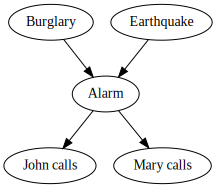

In [4]:
dot.render('round_table', directory='figures', format='svg', cleanup=True, view=True)
dot

**Task 1: convert the graph to Laplacian matrix (in degree), do this either on paper or just write out the matrix here**

In degree:
```
Adjacency_matrix = [0 0 1 0 0,
                    0 0 1 0 0,
                    0 0 0 1 1,
                    0 0 0 0 0,
                    0 0 0 0 0]
```

```
Degree_matrix = [0 0 0 0 0,
                 0 0 0 0 0,
                 0 0 2 0 0,
                 0 0 0 1 0,
                 0 0 0 0 1]
```


```
Laplacian_matrix = [0 0 -1 0 0,
                    0 0 -1 0 0,
                    0 0 2 -1 -1,
                    0 0 0 1 0,
                    0 0 0 0 1]

```


# Bayesian Network consutrction and inference

Read "alarm.png" file from the github link, use sorobn to construct the bayesian network

In [40]:
import sorobn as hh
import pandas as pd

bn = hh.BayesNet(
    ('Burglary', 'Alarm'),
    ('Earthquake', 'Alarm'),
    ('Alarm', 'John calls'),
    ('Alarm', 'Mary calls'),
    seed=42
  )

# P(Burglary)
bn.P['Burglary'] = pd.Series({False: .999, True: .001}) # P(Burglary=True) = 0.001, P(Burglary=False) = 0.999

# P(Earthquake)
bn.P['Earthquake'] = pd.Series({False: .998, True: .002}) # P(Earthquake=True) = 0.002, P(Earthquake=False) = 0.998

# P(Alarm | Burglary, Earthquake)
bn.P['Alarm'] = pd.Series({
              (True, True, True): .95, # P(Alarm=True | Burglary=True, Earthquake=True) = 0.95
              (True, True, False): .05, # P(Alarm=False | Burglary=True, Earthquake=True) = 0.05

              (True, False, True): .94, # P(Alarm=True | Burglary=True, Earthquake=False) = 0.94
              (True, False, False): .06, # P(Alarm=False | Burglary=True, Earthquake=False) = 0.06

              (False, True, True): .29, # P(Alarm=True | Burglary=False, Earthquake=True) = 0.29
              (False, True, False): .71, # P(Alarm=False | Burglary=False, Earthquake=True) = 0.71

              (False, False, True): .001, # P(Alarm=True | Burglary=False, Earthquake=False) = 0.001
              (False, False, False): .999 # P(Alarm=False | Burglary=False, Earthquake=False) = 0.999
          })




# P(John calls | Alarm)
bn.P['John calls'] = pd.Series({
     (True, True): .9, # P(John calls=True | Alarm=True) = 0.9
     (True, False): .1, # P(John calls=False | Alarm=True) = 0.1
     (False, True): .05,  # P(John calls=True | Alarm=False) = 0.05
     (False, False): .95  # P(John calls=False | Alarm=False) = 0.95
 })

# P(Mary calls | Alarm)
bn.P['Mary calls'] = pd.Series({
     (True, True): .7, # P(Mary calls=True | Alarm=True) = 0.7
     (True, False): .3,   # P(Mary calls=False | Alarm=True) = 0.3
     (False, True): .01, # P(Mary calls=True | Alarm=False) = 0.01
     (False, False): .99 # P(Mary calls=False | Alarm=False) = 0.99
 })


Make the network

In [41]:
bn.prepare()

# Bayesian network inference

What is the likelihood of there being a burglary if both John and Mary call?

In [34]:
bn.query('Burglary', event={'Mary calls': True, 'John calls': True})

,P(Burglary)
Burglary,
False,0.715828
True,0.284172


What are the chances that John and Mary call if an earthquake happens?

In [8]:
bn.query('John calls', 'Mary calls', event={'Earthquake': True})

John calls  Mary calls
False       False         0.675854
            True          0.027085
True        False         0.113591
            True          0.183470
Name: P(John calls, Mary calls), dtype: float64

Practice.png

In [47]:
bn = hh.BayesNet(
    ("A", "B"),
    ("B", "F"),
    ("C", "D"),
    ("D", "F"),
    seed=42,
) # Correct connections between nodes, just need to add probabilities like above

# P(A)
bn.P['A'] = pd.Series({False: 0.9, True: 0.1})

# P(B|A)
bn.P['B'] = pd.Series({
    (True, True): 0.4, # P(B = True | A = True)
    (True, False): 0.6, # P(B = False | A = True)

    (False, True): 0.9, #P(B = True | A = False)
    (False, False): 0.1 #P(B = False | A = False)
})

# P(C)
bn.P['C'] = pd.Series({False: 0.9, True: 0.1})

# P(D|C)
bn.P['D'] = pd.Series({
    (True, True): 0.3, # P(D = True | C = True)
    (True, False): 0.7, # P(D = False | C = True)

    (False, True): 0.6, #P(D = True | C = False)
    (False, False): 0.4 #P(D = False | C = False)
})


# P(F| B, D)
bn.P['F'] = pd.Series({
    (True, True, True): 0.7, # P(F = True | B = True, D = True)
    (True, True, False): 0.3, # P(F = False | B = True, D = True)

    (True, False, True): 0.4, #P(F = True | B = True, D = False)
    (True, False, False): 0.6, #P(F = False | B = True, D = False)

    (False, True, True): 0.2, #P(F = True | B = False, D = True)
    (False, True, False): 0.8, #P(F = False | B = False, D = True)

    (False, False, True): 0, #P(F = True | B = False, D = False)
    (False, False, False): 1 #P(F = False | B = False, D = False)
})

bn.prepare()

In [48]:
# test
print(bn.P['A'][False])               # P(A = False)
print(bn.P['B'][(False, False)])      # P(B = False | A = False)
print(bn.P['C'][True])                # P(C = True)
print(bn.P['D'][(True, True)])        # P(D = True | C = True)
print(bn.P['F'][(False, True, False)]) # P(F = False | B = False, D = True)


0.9
0.1
0.1
0.3
0.8


**Task 2:** What is the likelihood of F is true if A&D is true, B&C is False?

In [49]:
bn.query('F', event={'A': True, 'B': False, 'C': False, 'D': True})
# P(F=True|A=True, B=False, C=False, D=True) = 0.2

,P(F)
F,
False,0.8
True,0.2


**Task 3:** What is the likelihood of F is False if A&B is False, C&D is True?



In [50]:
bn.query('F', event={'A': False, 'B': False, 'C': True, 'D': True})
# P(F=False|A=False, B=False, C=True, D=True) = 0.8

,P(F)
F,
False,0.8
True,0.2
